In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/content/drive/MyDrive/Aprendizagem_de_Maquinas'
print(os.listdir(data_dir))

['Vitor_Sibin', 'Gabriel_Cari', 'Gustavo_Zago_Gabriel', 'Fabiano_Trindade ', 'Daniel_Antonio_Matheus', 'Jose_Daniel', 'Rodrigo_Secco', 'Bruno_Boreli', 'Iago_H', 'Matheus_Eduardo', 'Douglas_werneck']


In [ ]:
image_paths = []
labels = []

classes = os.listdir(data_dir)
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.endswith('.jpg'):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_name)

image_paths = np.array(image_paths)
labels = np.array(labels)

# Embaralhar os dados
indices = np.arange(len(image_paths))
np.random.shuffle(indices)
image_paths = image_paths[indices]
labels = labels[indices]

TENTATIVA DE UNDERSEMBLY NOS DADOS

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler()
image_paths_resampled, labels_resampled = oversampler.fit_resample(image_paths.reshape(-1, 1), labels)
image_paths = image_paths_resampled.flatten()
labels = labels_resampled


SEPARANDO OS DADOS EM TRAIN E VAL

In [ ]:
# Calcular o índice para divisão (80% para treino, 20% para validação)
split_idx = int(0.8 * len(image_paths))

# Dividir os dados em conjuntos de treino e validação
train_image_paths = image_paths[:split_idx]
train_labels = labels[:split_idx]
val_image_paths = image_paths[split_idx:]
val_labels = labels[split_idx:]

CONFIGURANDO A VALIDAÇÃO E UTILIZANDO GERADOR DE IMAGENS PARA AUXILIO DO TREINO

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range= 0.1,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Criar geradores de dados de treino e validação
train_generator = datagen.flow_from_directory(
    data_dir,
    seed = 8,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    seed = 8,
    class_mode='categorical',
    subset='validation'
)

num_train_images = train_generator.samples
num_val_images = validation_generator.samples

print(f'treinamento: {num_train_images}')
print(f' validação: {num_val_images}')

Found 484 images belonging to 11 classes.
Found 116 images belonging to 11 classes.
treinamento: 484
 validação: 116


VALIDAÇÃO CRUZADA


In [ ]:
from sklearn.model_selection import StratifiedKFold

Kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
    )

**CONSTRUINDO MODELO BASE**

In [ ]:
from tensorflow.keras.optimizers import Adam
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True

fine_tune_at = 100 # testando o fine tune

#for layer in base_model.layers[:-10]:
#   layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(11, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**ADICIONANDO CALLBACKS**

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_loss')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, patience=5,
    min_lr=1e-6)

**TREINANDO O MODELO**

In [ ]:

history = model.fit(
    train_generator,
    epochs=200,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    validation_data=validation_generator
)

NameError: name 'model' is not defined

**PLOTANDO EVOLUÇÃO DA PERDA E DA ACURACIA**

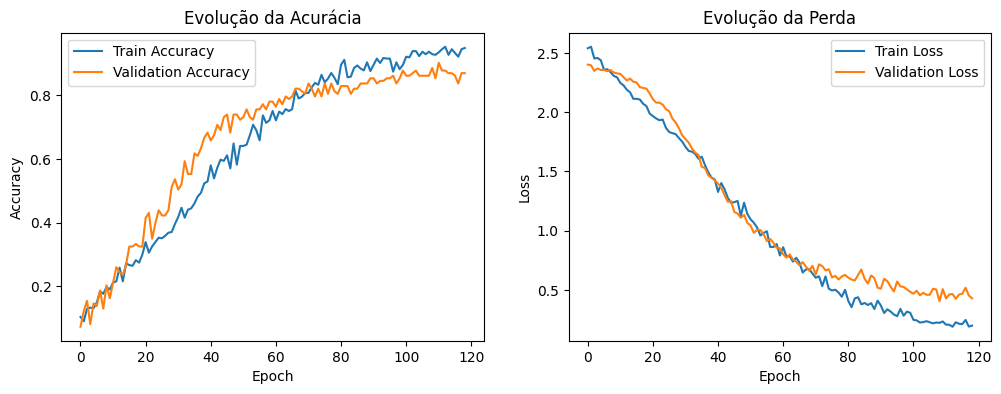

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evolução da Acurácia')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Evolução da Perda')

plt.show()


REALIZANDO TESTE DE IMAGEM

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Bruno_Boreli')

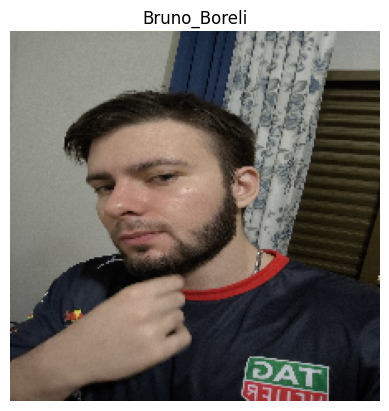

In [ ]:
from tensorflow.keras.preprocessing import image

test_img_path = '/content/drive/MyDrive/Aprendizagem_de_Maquinas/Bruno_Boreli/1716096835417.jpg'


img = image.load_img(test_img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array) #PREVISÃO DO MODELO
predicted_class = np.argmax(prediction)

# Obter o nome da classe prevista usando o índice
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]

# Exibir o resultado
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)


TESTE 2

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Daniel_Antonio_Matheus')

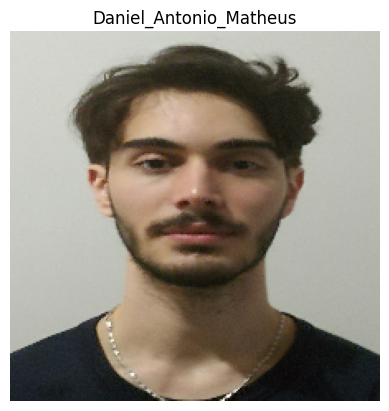

In [ ]:
test_img_path = '/content/drive/MyDrive/Aprendizagem_de_Maquinas/Daniel_Antonio_Matheus/IMG_20240521_164743.jpg'  # Substitua pelo caminho da sua imagem

img = image.load_img(
    test_img_path,
    target_size=(224, 224)
    )

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array) #PREVISÃO DO MODELO
predicted_class = np.argmax(prediction) #PREVISÃO DA CLASSE

class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]# PEGANDO O  NOME DA CLASSE

plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)

TESTE 3


1/1 [==============================] - 0s 33ms/step


Text(0.5, 1.0, 'Gustavo_Zago_Gabriel')

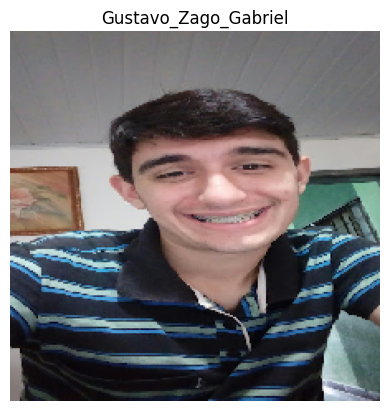

In [ ]:
test_img_path = '/content/drive/MyDrive/Aprendizagem_de_Maquinas/Gustavo_Zago_Gabriel/15.jpg'  # Substitua pelo caminho da sua imagem


img = image.load_img(test_img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array) #PREVISÃO DO MODELO
predicted_class = np.argmax(prediction) #PREVISÃO DA CLASSE

class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]# PEGANDO O  NOME DA CLASSE

plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Matheus_Eduardo')

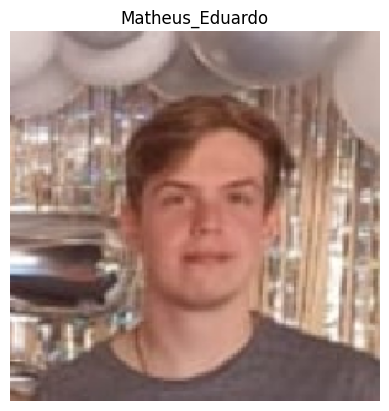

In [ ]:
test_img_path = '/content/drive/MyDrive/Aprendizagem_de_Maquinas/Matheus_Eduardo/Screenshot_15.jpg'


img = image.load_img(test_img_path, target_size=(224, 224))


img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)


class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]

plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)

8/8 [==============================] - 8s 839ms/step


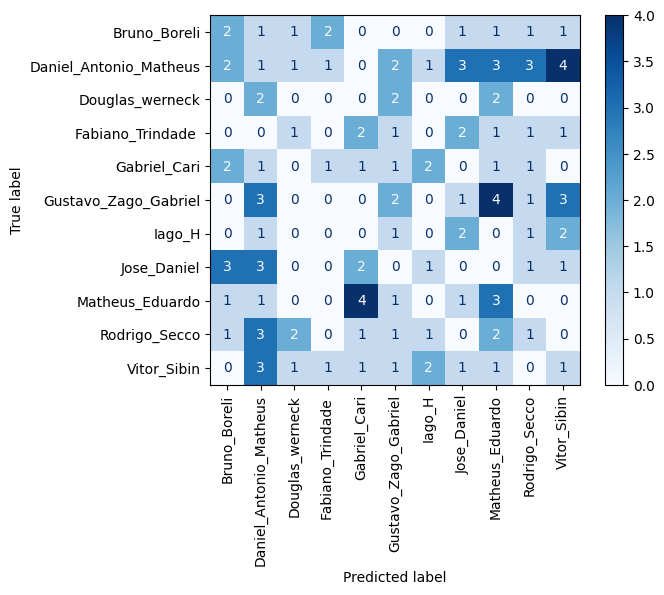

1/1 [==============================] - 0s 22ms/step


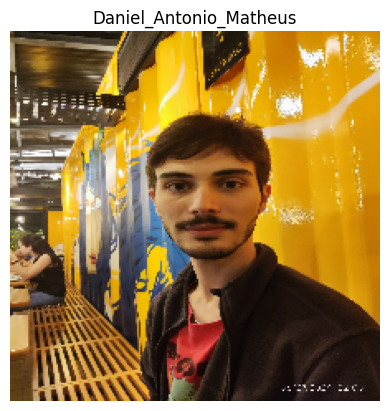

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_predictions = model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Obter rótulos verdadeiros do conjunto de validação
val_true_classes = validation_generator.classes

# Obter nomes das classes
class_labels = list(validation_generator.class_indices.keys())

# Calcular a matriz de confusão
cm = confusion_matrix(val_true_classes, val_predicted_classes)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

# Importar bibliotecas adicionais
from tensorflow.keras.preprocessing import image

# Caminho para a imagem de teste
test_img_path = '/content/drive/MyDrive/Aprendizagem_de_Maquinas/Daniel_Antonio_Matheus/danitest.jpg'  # Substitua pelo caminho da sua imagem

# Carregar a imagem de teste e redimensioná-la para o tamanho esperado (224x224)
img = image.load_img(test_img_path, target_size=(224, 224))

# Pré-processamento da imagem (conversão para array numpy e normalização)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Fazer a previsão usando o modelo treinado
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Obter o nome da classe prevista usando o índice
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]

# Exibir o resultado
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)
plt.show()